In [ ]:
pip install geopandas matplotlib

In [ ]:
pip install tslearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 2.3 MB/s eta 0:00:00


In [ ]:
from google.colab import drive #import drive from google.colab
drive.mount('/content/drive') #mount google drive

Mounted at /content/drive


In [ ]:
#Importing required modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import geopandas as gpd
from sklearn.cluster import KMeans
from tslearn.clustering import TimeSeriesKMeans
import matplotlib.colors as mcolors

In [ ]:
def normalise(df):
  """ This function normalises the dataframe using standard scaler"""
  scaler = StandardScaler()
  df[['Emission', 'Fertlizer_consumption', 'Temperature']] = scaler.fit_transform(df[['Emission', 'Fertlizer_consumption', 'Temperature']])
  return df

def add_label(x, y):
  """A function to add labels inside a plot"""
  for i in range (len(x)):
    plt.text(i+1.6, y[i], round(y[i], 3), fontsize=5)

In [ ]:
forecast_df = pd.read_excel('/content/drive/MyDrive/final_project/EML_forecast/forecast_data.xlsx')

In [ ]:
#Dropping unnamed column from  dataframe
forecast_df = forecast_df.drop(columns=['Unnamed: 0'], axis=1)
print(forecast_df)

      Year      Country   Emission  Fertlizer_consumption  Temperature
0     1961  Afghanistan  2917273.5                   0.13    11.336061
1     1962  Afghanistan  2891160.8                   0.13    11.144664
2     1963  Afghanistan  2941533.2                   0.13    12.411098
3     1964  Afghanistan  3004207.0                   0.13    10.428792
4     1965  Afghanistan  3075739.0                   0.13    11.212704
...    ...          ...        ...                    ...          ...
7864  2017     Zimbabwe  5147235.0                  15.85    21.228878
7865  2018     Zimbabwe  5237749.0                  12.22    21.909628
7866  2019     Zimbabwe  5149571.5                  12.22    22.434425
7867  2020     Zimbabwe  4687377.5                   9.59    21.785597
7868  2021     Zimbabwe  4966384.0                   9.59    21.573135

[7869 rows x 5 columns]


In [ ]:
#Converting Year column to date format
forecast_df['Year'] = pd.to_datetime(forecast_df['Year'], format='%Y')
#Removing all the entries where Country is equal to World
forecast_df = forecast_df[forecast_df['Country']!="World"]
print(forecast_df)

           Year      Country   Emission  Fertlizer_consumption  Temperature
0    1961-01-01  Afghanistan  2917273.5                   0.13    11.336061
1    1962-01-01  Afghanistan  2891160.8                   0.13    11.144664
2    1963-01-01  Afghanistan  2941533.2                   0.13    12.411098
3    1964-01-01  Afghanistan  3004207.0                   0.13    10.428792
4    1965-01-01  Afghanistan  3075739.0                   0.13    11.212704
...         ...          ...        ...                    ...          ...
7864 2017-01-01     Zimbabwe  5147235.0                  15.85    21.228878
7865 2018-01-01     Zimbabwe  5237749.0                  12.22    21.909628
7866 2019-01-01     Zimbabwe  5149571.5                  12.22    22.434425
7867 2020-01-01     Zimbabwe  4687377.5                   9.59    21.785597
7868 2021-01-01     Zimbabwe  4966384.0                   9.59    21.573135

[7808 rows x 5 columns]


In [ ]:
#Calculating yearly average of nitrous oxide emission , fertilizer consumption and surface temperature
avg_yearly_forecast_df = forecast_df.groupby('Year')[['Emission', 'Fertlizer_consumption', 'Temperature']].mean()

In [ ]:
# Normalising the values
norm_avg_yearly_forecast_df = normalise(avg_yearly_forecast_df)

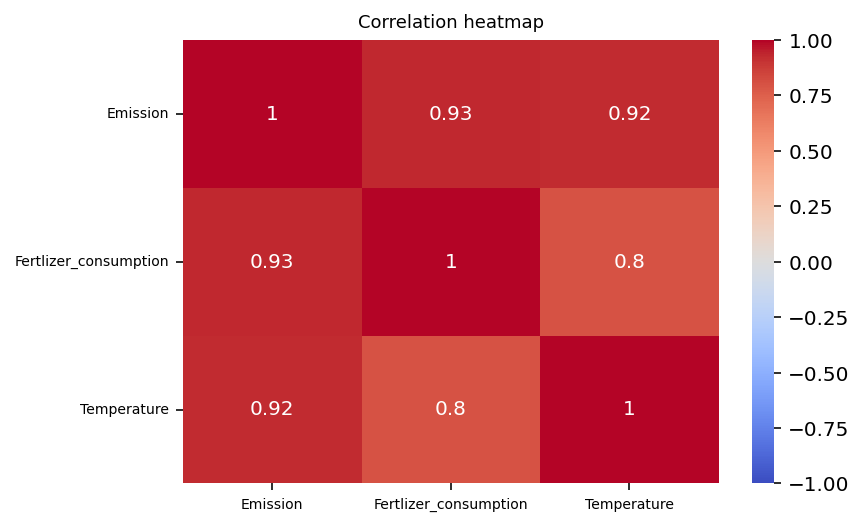

In [ ]:
#Correlation heatmap to show the correltion between variables
plt.figure(dpi=144, figsize=(6,4))
corr_matrix = norm_avg_yearly_forecast_df[['Emission', 'Fertlizer_consumption', 'Temperature']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.title("Correlation heatmap", fontsize=9)
plt.show()

In [ ]:
#Normalising the values of Cluster_df using standard scaler
norm_forecast_df= forecast_df.groupby("Country").apply(lambda x:normalise(x)).reset_index(drop=True)

In [ ]:
#Creating a correlation heatmap to explain the correlation between variables

i=0
for r in range(32):
  f, ax = plt.subplots(1, 4, figsize=(30,5), dpi=144)
  ax = ax.flatten()
  for c in range(4):
    country = norm_forecast_df['Country'].unique()[i]
    country_df = norm_forecast_df[norm_forecast_df['Country']==country]
    corr_matrix = country_df[['Emission', 'Fertlizer_consumption', 'Temperature']].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=ax[c])
    ax[c].set_title(country, fontsize=10)
    i=i+1
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

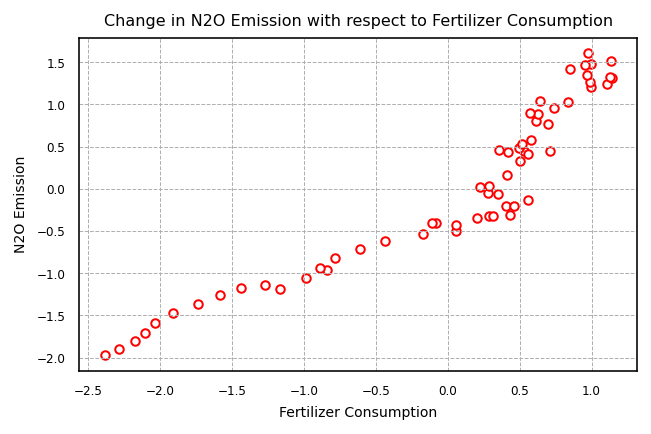

In [ ]:
#Creating a scatter plot to show the correlation between Nitrous oxide emission
#and Fertilizer consumption
plt.figure(dpi=144 ,figsize=(5,3))
plt.scatter(x=norm_avg_yearly_forecast_df['Fertlizer_consumption'], y=norm_avg_yearly_forecast_df['Emission'],
            s=18, facecolor='white', edgecolor='red')
plt.xlabel("Fertilizer Consumption", fontsize=7)
plt.ylabel("N2O Emission", fontsize=7)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.grid(linewidth=0.5, linestyle='--')
ax = plt.gca()
ax.tick_params(left=False, bottom=False)
plt.title("Change in N2O Emission with respect to Fertilizer Consumption", fontsize=8)
plt.show()

In [ ]:
#Creating the scatter plot to show the correlation between N2O Emission and
#fertilizer consumption across different countries
i=0
for r in range(32):
  f, ax = plt.subplots(1, 4, figsize=(30,5), dpi=144)
  ax = ax.flatten()
  for c in range(4):
    country = norm_forecast_df['Country'].unique()[i]
    country_df = norm_forecast_df[norm_forecast_df['Country']==country]
    ax[c].scatter(x=country_df['Fertlizer_consumption'], y=country_df['Emission'],
                   facecolor='white', edgecolor='red')
    ax[c].set_xlabel('Fertilizer Consumption', fontsize=8)
    ax[c].set_ylabel('N2O Emission', fontsize=8)
    ax[c].set_title(country, fontsize=10)
    i=i+1
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

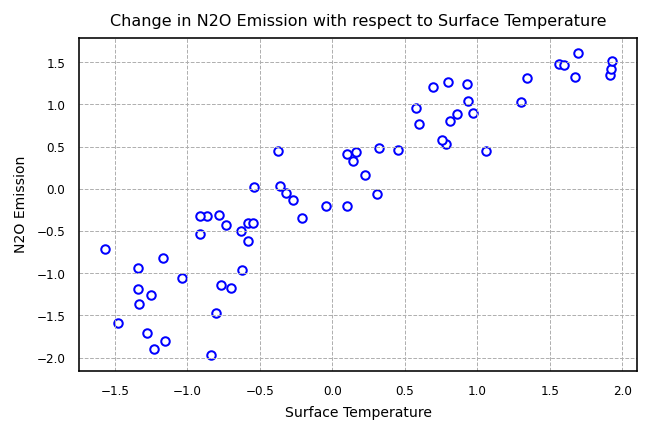

In [ ]:

#Plotting a scatter plot to show the correlation between Nitrous Oxide emission
#and temperature
plt.figure(dpi=144, figsize=(5,3))
plt.scatter(x=norm_avg_yearly_forecast_df['Temperature'], y=norm_avg_yearly_forecast_df['Emission'],
            s=18, facecolor='white', edgecolor='blue')
plt.xlabel("Surface Temperature", fontsize=7)
plt.ylabel("N2O Emission", fontsize=7)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.grid(linewidth=0.5, linestyle='--')
ax = plt.gca()
ax.tick_params(left=False, bottom=False)
plt.title("Change in N2O Emission with respect to Surface Temperature", fontsize=8)
plt.show()

In [ ]:
#Creating the scatter plot to show the correlation between N2O Emission and
#temperature across different countries
i=0
for r in range(32):
  f, ax = plt.subplots(1, 4, figsize=(30,5), dpi=144)
  ax = ax.flatten()
  for c in range(4):
    country = norm_forecast_df['Country'].unique()[i]
    country_df = norm_forecast_df[norm_forecast_df['Country']==country]
    ax[c].scatter(x= country_df['Temperature'], y= country_df['Emission'],
                   facecolor='white', edgecolor='blue')
    ax[c].set_xlabel('Temperature', fontsize=8)
    ax[c].set_ylabel('N2O Emission', fontsize=8)
    ax[c].set_title(country, fontsize=10)
    i=i+1
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
pivot_forecast_df = norm_forecast_df.pivot(index="Year", columns = "Country", values='Emission')

In [ ]:
print(pivot_forecast_df)

Country     Afghanistan   Albania   Algeria    Angola  Argentina  Australia  \
Year                                                                          
1961-01-01    -0.712272 -1.880740 -1.543655 -1.154992  -1.542932  -1.188309   
1962-01-01    -0.751117 -1.863443 -1.508476 -1.142133  -1.598983  -1.067309   
1963-01-01    -0.676183 -1.898035 -1.558351 -1.132957  -1.775032  -0.995242   
1964-01-01    -0.582949 -1.852313 -1.543670 -1.112961  -1.516060  -0.879565   
1965-01-01    -0.476538 -1.661071 -1.435603 -1.092478  -1.206775  -0.825380   
...                 ...       ...       ...       ...        ...        ...   
2017-01-01     2.226094  0.396366  1.738142  1.326149   1.907856   0.852372   
2018-01-01     2.083739 -0.100591  1.814894  0.897106   1.762360   0.709590   
2019-01-01     1.766261  0.003037  1.860995  1.369345   2.125832  -0.470699   
2020-01-01     1.655276 -0.432531  1.710426  1.178681   2.348955  -1.369867   
2021-01-01     1.426868 -1.445299  1.737075  1.22495

In [ ]:
cluster_df = pivot_forecast_df.values.transpose()

In [ ]:
print(cluster_df)

[[-0.71227186 -0.75111729 -0.67618297 ...  1.76626108  1.65527594
   1.42686805]
 [-1.88073985 -1.86344332 -1.8980351  ...  0.00303686 -0.43253067
  -1.44529941]
 [-1.54365522 -1.5084756  -1.55835111 ...  1.86099502  1.71042596
   1.73707476]
 ...
 [-1.0985256  -1.0844603  -1.07029572 ...  1.56248471  1.49020692
   1.50278872]
 [-1.28602415 -1.27712965 -1.26007646 ...  1.42807787  1.29734245
   1.2758825 ]
 [-2.24099304 -2.21743626 -2.16021198 ...  0.40341728 -0.12003472
   0.19595058]]


In [ ]:
#Calculating the optimal number of clusters using elbow method
sse = []
for i in range(1,10):
  model = TimeSeriesKMeans(n_clusters=i,metric="dtw", random_state=42,init="k-means++", n_init=10)
  model.fit(cluster_df)
  sse.append(model.inertia_)



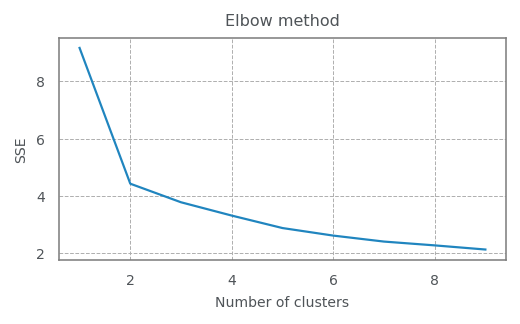

In [ ]:
plt.figure(dpi=144, figsize=(4,2))
plt.plot(range(1,10), sse,linewidth = 1.1, color = '#2085bf')
plt.xlabel("Number of clusters", fontsize=7, color='#4f5458')
plt.grid(linewidth=0.5, linestyle='--')
plt.ylabel("SSE", fontsize=7, color='#4f5458')
plt.grid(linewidth=0.5, linestyle='--')
plt.xticks(fontsize=7, color='#4f5458')
plt.yticks(fontsize=7, color='#4f5458')
ax = plt.gca()
ax.spines['top'].set_color('grey')
ax.spines['right'].set_color('grey')
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
plt.title("Elbow method",fontsize=8, color='#4f5458')
plt.show()

In [ ]:
#Calcualating Silhouette score to find the optimal number of clusters

s_score = []
for i in range(2,10):
  model = TimeSeriesKMeans(n_clusters=i,metric="dtw", random_state=42,init="k-means++", n_init=10)
  labels = model.fit_predict(cluster_df)
  s_avg = silhouette_score(cluster_df, labels)
  s_score.append(s_avg)



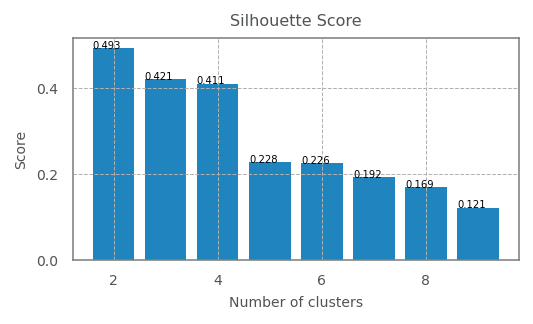

In [ ]:


plt.figure(dpi=144, figsize=(4,2))
plt.bar(range(2,10), s_score, color='#2085bf')
add_label(range(2,10), s_score)
plt.xlabel("Number of clusters", fontsize=7, color='#4f5458')
plt.grid(linewidth=0.5, linestyle='--')
plt.ylabel("Score", fontsize=7, color='#4f5458')
plt.grid(linewidth=0.5, linestyle='--')
plt.xticks(fontsize=7, color='#4f5458')
plt.yticks(fontsize=7, color='#4f5458')
ax = plt.gca()
ax.spines['top'].set_color('grey')
ax.spines['right'].set_color('grey')
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
plt.title("Silhouette Score",fontsize=8, color='#4f5458')
plt.show()

In [ ]:
#Applying KMeans clustering algorithm with number of clusters equal to 2
model = TimeSeriesKMeans(n_clusters=2,metric="dtw", random_state=42,init="k-means++", n_init=10)
labels = model.fit_predict(cluster_df)

# Create a dataframe with cluster labels
country_labels = pd.DataFrame({'Country': norm_forecast_df['Country'].unique(), 'Cluster': labels})

In [ ]:
#Merging the actual forecast_df with country_labels by Country column
cluster_forecast_df = pd.merge(forecast_df, country_labels, on=('Country'))
print(cluster_forecast_df)

           Year      Country   Emission  Fertlizer_consumption  Temperature  \
0    1961-01-01  Afghanistan  2917273.5                   0.13    11.336061   
1    1962-01-01  Afghanistan  2891160.8                   0.13    11.144664   
2    1963-01-01  Afghanistan  2941533.2                   0.13    12.411098   
3    1964-01-01  Afghanistan  3004207.0                   0.13    10.428792   
4    1965-01-01  Afghanistan  3075739.0                   0.13    11.212704   
...         ...          ...        ...                    ...          ...   
7803 2017-01-01     Zimbabwe  5147235.0                  15.85    21.228878   
7804 2018-01-01     Zimbabwe  5237749.0                  12.22    21.909628   
7805 2019-01-01     Zimbabwe  5149571.5                  12.22    22.434425   
7806 2020-01-01     Zimbabwe  4687377.5                   9.59    21.785597   
7807 2021-01-01     Zimbabwe  4966384.0                   9.59    21.573135   

      Cluster  
0           0  
1           0  
2  

In [ ]:
#Creating seperate dataframe for each of the clusters
cluster0_df = cluster_forecast_df[cluster_forecast_df['Cluster']==0]
cluster1_df = cluster_forecast_df[cluster_forecast_df['Cluster']==1]


<ipython-input-56-b8676833d318>:3: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


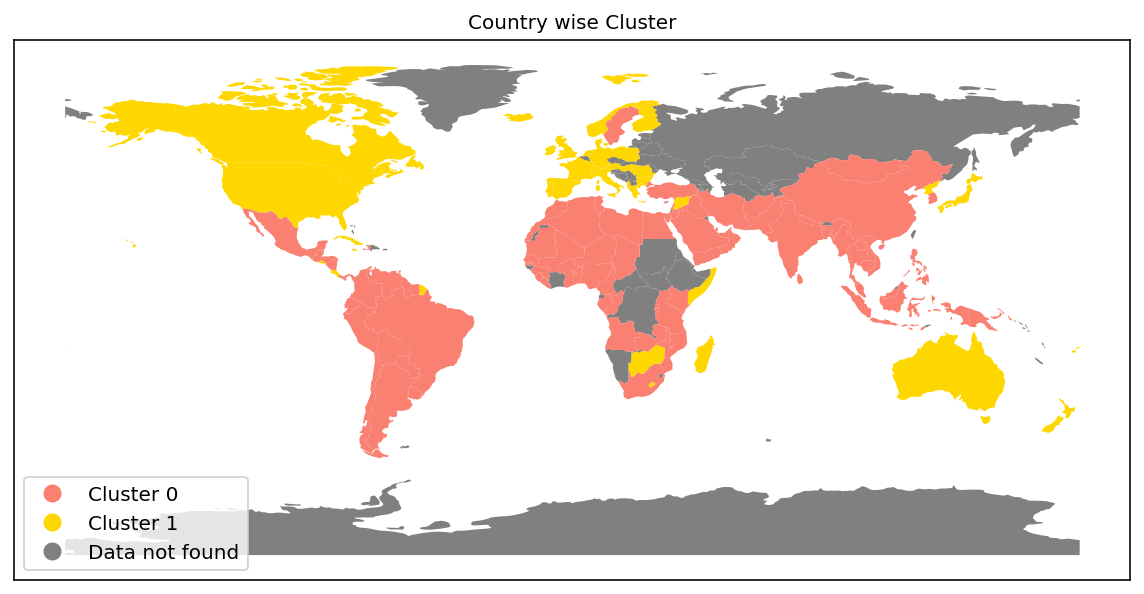

In [ ]:
# Creating a plot to show the cluster distribution across the globe
country_labels['Country'] = country_labels['Country'].replace("United States", "United States of America")
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
merged = world.set_index('name').join(country_labels.set_index('Country'))

cluster_colors = {
    0: 'Salmon',
    1: 'Gold'
}
# Created a new column to map the cluster values to colors
merged['color'] = merged['Cluster'].map(cluster_colors)
# Handle NaN values separately by setting them to grey
merged['color'] = merged['color'].fillna('grey')

fig, ax = plt.subplots(1, 1,dpi=144, figsize=(10, 7))
merged.plot(color=merged['color'], ax=ax, legend=False)

# Customized legend
handles = [
    plt.Line2D([0], [0], marker='o', color='w', label='Cluster 0', markersize=10, markerfacecolor='Salmon'),
    plt.Line2D([0], [0], marker='o', color='w', label='Cluster 1', markersize=10, markerfacecolor='Gold'),
    plt.Line2D([0], [0], marker='o', color='w', label='Data not found', markersize=10, markerfacecolor='grey')
]
ax.legend(handles=handles, loc='lower left')
ax.set_xticks([])
ax.set_yticks([])
plt.title('Country wise Cluster', fontsize=10)
plt.show()

In [ ]:
print(cluster0_df)

           Year      Country    Emission  Fertlizer_consumption  Temperature  \
0    1961-01-01  Afghanistan   2917273.5                   0.13    11.336061   
1    1962-01-01  Afghanistan   2891160.8                   0.13    11.144664   
2    1963-01-01  Afghanistan   2941533.2                   0.13    12.411098   
3    1964-01-01  Afghanistan   3004207.0                   0.13    10.428792   
4    1965-01-01  Afghanistan   3075739.0                   0.13    11.212704   
...         ...          ...         ...                    ...          ...   
7742 2017-01-01       Zambia  11994557.0                  54.88    21.990713   
7743 2018-01-01       Zambia  11803826.0                  38.55    22.302803   
7744 2019-01-01       Zambia  12415978.0                  43.67    22.617643   
7745 2020-01-01       Zambia  12135877.0                  49.94    22.167978   
7746 2021-01-01       Zambia  12089899.0                  46.53    22.126863   

      Cluster  
0           0  
1      

In [ ]:
# Calculating the average emission, fertilizer consumption and temperature of clusters
avg_cluster0_df = cluster0_df.groupby('Year')[['Emission', 'Fertlizer_consumption', 'Temperature']].mean()
avg_cluster1_df = cluster1_df.groupby('Year')[['Emission', 'Fertlizer_consumption', 'Temperature']].mean()

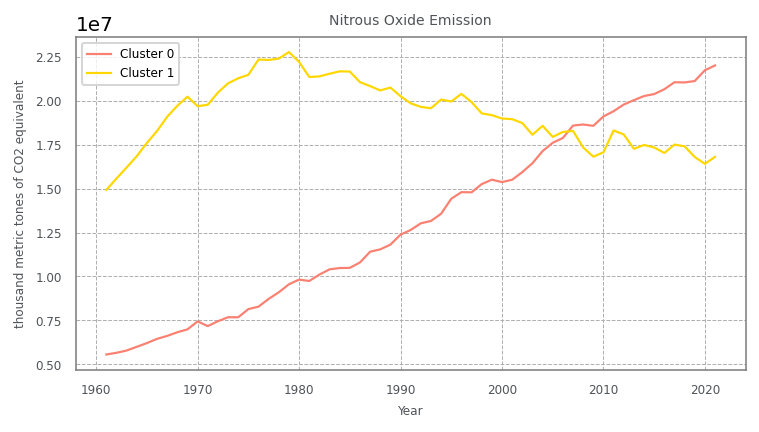

In [ ]:
#Line plot to show the cluster wise trend in N2O emission
plt.figure(dpi=144, figsize=(6,3))
plt.plot(avg_cluster0_df.index, avg_cluster0_df['Emission'],
           linewidth = 1.1, color='Salmon', label="Cluster 0")
plt.plot(avg_cluster1_df.index, avg_cluster1_df['Emission'],
           linewidth = 1.1, color='Gold', label='Cluster 1')
plt.xlabel("Year", fontsize=6, color='#4f5458')
plt.ylabel("thousand metric tones of CO2 equivalent", fontsize=6, color='#4f5458')
plt.grid(linewidth=0.5, linestyle='--')
plt.xticks(fontsize=6, color='#4f5458')
plt.yticks(fontsize=6, color='#4f5458')
ax = plt.gca()
ax.spines['top'].set_color('grey')
ax.spines['right'].set_color('grey')
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
plt.legend(fontsize=6)
plt.title("Nitrous Oxide Emission", fontsize=7, color='#4f5458')
plt.show()

In [ ]:
#Normalising the values for both the cluster dataframes
cluster0_df_norm = cluster0_df.groupby("Country").apply(lambda x : normalise(x))
cluster1_df_norm = cluster1_df.groupby("Country").apply(lambda x : normalise(x))

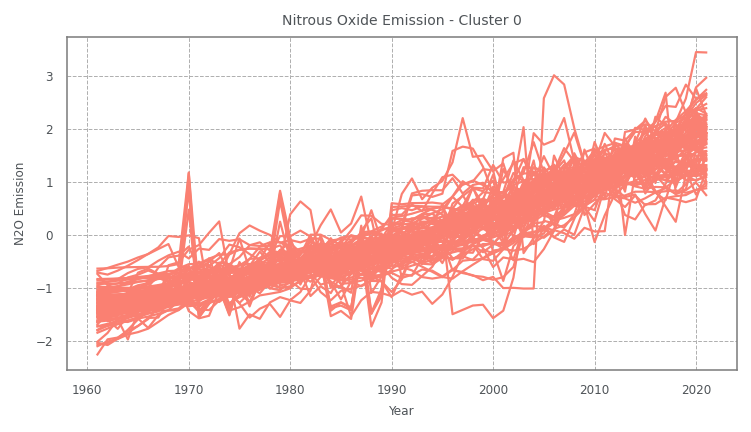

In [ ]:
#Line plot to show the trend in nitrous oxide emission of countries in cluster 0
plt.figure(dpi=144, figsize=(6,3))
for country in cluster0_df_norm['Country'].unique():
  cluster_country = cluster0_df_norm[cluster0_df_norm['Country']==country]
  plt.plot(cluster_country["Year"], cluster_country['Emission'],
           linewidth = 1.1, color='Salmon')
plt.xlabel("Year", fontsize=6, color='#4f5458')
plt.ylabel("N2O Emission", fontsize=6, color='#4f5458')
plt.grid(linewidth=0.5, linestyle='--')
plt.xticks(fontsize=6, color='#4f5458')
plt.yticks(fontsize=6, color='#4f5458')
ax = plt.gca()
ax.spines['top'].set_color('grey')
ax.spines['right'].set_color('grey')
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
plt.title("Nitrous Oxide Emission - Cluster 0", fontsize=7, color='#4f5458')
plt.show()

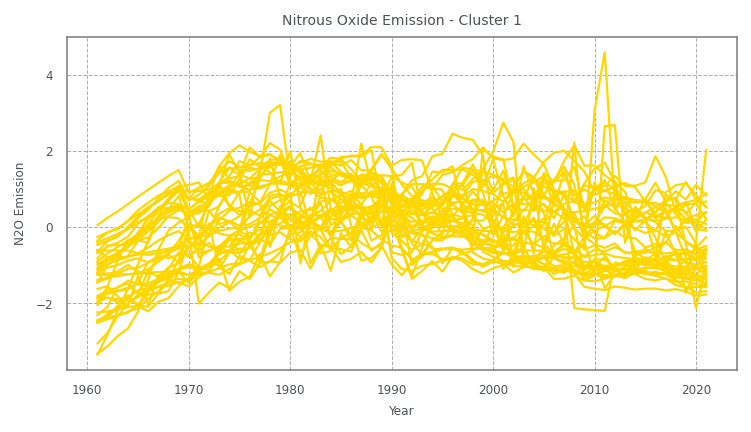

In [ ]:
#Line plot to show the trend in nitrous oxide emission of countries in cluster 1
plt.figure(dpi=144, figsize=(6,3))
for country in cluster1_df_norm['Country'].unique():
  cluster_country = cluster1_df_norm[cluster1_df_norm['Country']==country]
  plt.plot(cluster_country["Year"], cluster_country['Emission'],
           linewidth = 1.1, color='gold')
plt.xlabel("Year", fontsize=6, color='#4f5458')
plt.ylabel("N2O Emission", fontsize=6, color='#4f5458')
plt.grid(linewidth=0.5, linestyle='--')
plt.xticks(fontsize=6, color='#4f5458')
plt.yticks(fontsize=6, color='#4f5458')
ax = plt.gca()
ax.spines['top'].set_color('grey')
ax.spines['right'].set_color('grey')
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
plt.title("Nitrous Oxide Emission - Cluster 1", fontsize=7, color='#4f5458')
plt.show()